- GpuRIR을 사용하려 했으나 설치가 안됐음

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" Example for computing the RIR between several sources and receivers in GPU."""

import os
import numpy as np
from math import ceil, cos, sin
import math
from scipy.io import wavfile
from multiprocessing import Pool

fs = 16000

def main(key, room_sz, T60, mic_tilt, delta, save_dir):
    import gpuRIR
    gpuRIR.activateMixedPrecision(False)
    gpuRIR.activateLUT(True)

    mic_tilt_rad = mic_tilt*math.pi/180
    deg_60 = math.pi/3
    mic_c = np.array([room_sz[0]/2, room_sz[1]/2, 0.5]) + np.array(delta)
    r = 0.0425
    mic_array = np.array([
                [mic_c[0], mic_c[1], mic_c[2]], 
                [mic_c[0] + r*cos(0*deg_60+mic_tilt_rad), mic_c[1] + r*sin(0*deg_60+mic_tilt_rad), mic_c[2]],
                [mic_c[0] + r*cos(1*deg_60+mic_tilt_rad), mic_c[1] + r*sin(1*deg_60+mic_tilt_rad), mic_c[2]],
                [mic_c[0] + r*cos(2*deg_60+mic_tilt_rad), mic_c[1] + r*sin(2*deg_60+mic_tilt_rad), mic_c[2]],
                [mic_c[0] + r*cos(3*deg_60+mic_tilt_rad), mic_c[1] + r*sin(3*deg_60+mic_tilt_rad), mic_c[2]],
                [mic_c[0] + r*cos(4*deg_60+mic_tilt_rad), mic_c[1] + r*sin(4*deg_60+mic_tilt_rad), mic_c[2]],
                [mic_c[0] + r*cos(5*deg_60+mic_tilt_rad), mic_c[1] + r*sin(5*deg_60+mic_tilt_rad), mic_c[2]]
                ])
        
    for idx in range(200):
        pos_src = mic_c
        while np.linalg.norm(pos_src[0:2] - mic_c[0:2]) < 0.75:
            x = np.random.uniform(low=0.3,high=room_sz[0]-0.3)
            y = np.random.uniform(low=0.3,high=room_sz[1]-0.3)
            z = np.random.uniform(low=1.0,high=1.5)
            pos_src = np.array([x,y,z]) # Positions of the sources ([m]
            
        mic_pattern = "omni" # Receiver polar pattern
        orV_rcv=None # None for omni

        abs_weights = [0.9]*5+[0.5] # Absortion coefficient ratios of the walls
        att_diff = 25.0    # !Attenuation when start using the diffuse reverberation model [dB]
        att_max = 60.0 # Attenuation at the end of the simulation [dB]

        beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
        Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
        Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)     # Time to stop the simulation [s]
        nb_img = gpuRIR.t2n( Tdiff, room_sz )    # Number of image sources in each dimension
        RIRs = gpuRIR.simulateRIR(room_sz, beta, np.expand_dims(pos_src,axis=0), mic_array, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)
        sub_dir = '/RIR_sample_room_'+key+'/tilt_'+str(mic_tilt)+'_delta_'+str(delta[0])+'_'+str(delta[1])+'/T60_'+str(T60)
        file_name = '/location_'+str(round(x,2))+'_'+str(round(y,2))+'_'+str(round(z,2))+'.wav'
        os.makedirs(save_dir+sub_dir, exist_ok=True)
        wavfile.write(save_dir+sub_dir+file_name, fs, np.transpose(RIRs[0]))

    print("Generating RIR filters for Room = {}, RT = {}, tilte={}, mic. location = {} done.".format(
        key, T60, mic_tilt, delta))

def chunkify(lst, n):
    return [lst[i::n] for i in range(n)]

if __name__ == "__main__":
    rt_list = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
    rooms = {
             'small_0' :[4.01, 3.65, 2.81],
             'small_1' :[6.02, 3.82, 2.53],
             'small_2' :[3.35, 4.94, 2.83],
             'small_3' :[4.55, 5.76, 2.61],
             'small_4' :[5.33, 3.51, 2.72],
             'small_5' :[4.34, 6.02, 2.55],
             'small_6' :[4.55, 3.54, 2.81],
             'small_7' :[4.76, 3.86, 2.74],
             'small_8' :[4.87, 3.78, 2.57],
             'small_9' :[5.08, 4.02, 2.64],
             'medium_0':[5.94, 7.45, 2.82],
             'medium_1':[7.40, 5.55, 2.87],
             'medium_2':[7.13, 5.78, 2.82],
             'medium_3':[7.23, 5.22, 2.91],
             'medium_4':[8.12, 5.45, 3.01],
             'medium_5':[8.20, 5.55, 2.89],
             'medium_6':[6.63, 4.75, 2.84],
             'medium_7':[6.30, 6.15, 2.92],
             'medium_8':[8.40, 5.45, 2.95],
             'medium_9':[8.10, 6.42, 3.00]
             }
    mic_tilts = [0,20,40]
    location_delta = [[-0.52, -0.15, -0.11],
                      [-0.35, -0.41, 0.09],
                      [-0.16, 0.38, -0.10],
                      [-0.45, 0.20, 0.12],
                      [0.45, -0.18, -0.14],
                      [0.55, -0.33, 0.08],
                      [0.31, 0.22, 0.02],
                      [0.27, 0.43, -0.03]]
    root_dir = "/home/nas/user/Uihyeop/DB/RIR_filter_v13"
    dict_list = [(key,room_sz,T60, mic_tilt, delta, root_dir) 
                 for T60 in rt_list
                 for mic_tilt in mic_tilts
                 for delta in location_delta
                 for key, room_sz in rooms.items()]

    num_chunks = 10  # 프로세스 수를 CPU 코어 수로 설정
    chunked_dict_list = chunkify(dict_list, num_chunks)

    # with Pool(num_chunks) as p:
    #     for chunk in chunked_dict_list:
    #         p.starmap(main, chunk)

# RIR Generator사용
### Generate speech rir

In [7]:
""" Example for computing the RIR between 2 sources(speech, echo) and 2 receivers. """

import os
import numpy as np
from math import ceil, cos, sin
import math
from scipy.io import wavfile
from multiprocessing import Pool
import rir_generator as rir


fs = 16000

def main(key, room_sz, T60, save_dir):
    deg_60 = math.pi/3
    mic_1 = np.array([2.0, 1.5, 0.15])
    d = 0.08
    mic_2 = mic_1 + np.array([d*cos(deg_60), d*sin(deg_60), 0])
    mic_array = np.array([
                [mic_1[0], mic_1[1], mic_1[2]], 
                [mic_2[0], mic_2[1], mic_2[2]], 
                ])
        
    for idx in range(10):
        pos_src = mic_1
        while np.linalg.norm(pos_src[0:2] - mic_1[0:2]) < 3.0:
            x = np.random.uniform(low=0.3,high=room_sz[0]-0.3)
            y = np.random.uniform(low=0.3,high=room_sz[1]-0.3)
            z = np.random.uniform(low=1.0,high=1.5)
            pos_src = np.array([x,y,z]) # Positions of the sources ([m]
            
        RIRs = rir.generate(
            c=340,                  # Sound velocity (m/s)
            fs=fs,                  # Sample frequency (samples/s)
            r=mic_array,
            s=pos_src,          # Source position [x y z] (m)
            L=room_sz,            # Room dimensions [x y z] (m)
            reverberation_time=T60, # Reverberation time (s)
            nsample=int(T60*fs),           # Number of output samples
        )
        sub_dir = '/RIR_sample_room_'+key+'/T60_'+str(T60)
        file_name = '/location_'+str(round(x,2))+'_'+str(round(y,2))+'_'+str(round(z,2))+'.wav'
        os.makedirs(save_dir+sub_dir, exist_ok=True)
        wavfile.write(save_dir+sub_dir+file_name, fs, RIRs)

    print("Generating RIR filters for Room = {}, RT = {} done.".format(key, T60))

def chunkify(lst, n):
    return [lst[i::n] for i in range(n)]

if __name__ == "__main__":
    rt_list = [0.25, 0.3, 0.35, 0.4]
    rooms = {
             'medium_0':[8, 6, 3],
             }
    root_dir = "./RIR_filters"
    dict_list = [(key,room_sz,T60, root_dir) 
                 for T60 in rt_list
                 for key, room_sz in rooms.items()]
    # for room in rooms:
    #     for T60 in rt_list:
    #         main(room, rooms[room], T60, root_dir) # Run part

### Generate Echo rir

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" Example for computing the RIR between several sources and receivers in GPU.
"""

import os
import numpy as np
from math import ceil, cos, sin
import math
from scipy.io import wavfile
from multiprocessing import Pool
import rir_generator as rir


fs = 16000

def main(key, room_sz, T60, save_dir):
    deg_60 = math.pi/3
    mic_1 = np.array([2, 1.5, 0.15])
    d = 0.08
    mic_2 = mic_1 + np.array([d*cos(deg_60), d*sin(deg_60), 0])
    mic_array = np.array([
                [mic_1[0], mic_1[1], mic_1[2]], 
                [mic_2[0], mic_2[1], mic_2[2]], 
                ])
        
    d_echo = 0.3
    pos_src = mic_1 + np.array([d_echo*cos(deg_60*2.5), d_echo*sin(deg_60*2.5), 0])
    x, y, z = pos_src
    
    RIRs = rir.generate(
        c=340,                  # Sound velocity (m/s)
        fs=fs,                  # Sample frequency (samples/s)
        r=mic_array,
        s=pos_src,          # Source position [x y z] (m)
        L=room_sz,            # Room dimensions [x y z] (m)
        reverberation_time=T60, # Reverberation time (s)
        nsample=int(T60*fs),           # Number of output samples
    )

    sub_dir = '/RIR_sample_room_'+key+'/T60_'+str(T60)
    file_name = '/echo_'+str(round(x,2))+'_'+str(round(y,2))+'_'+str(round(z,2))+'.wav'
    os.makedirs(save_dir+sub_dir, exist_ok=True)
    wavfile.write(save_dir+sub_dir+file_name, fs, RIRs)
    
    print("Generating RIR filters for Room = {}, RT = {} done.".format(key, T60))
    
def chunkify(lst, n):
    return [lst[i::n] for i in range(n)]

if __name__ == "__main__":
    rt_list = [0.25, 0.3, 0.35, 0.4]
    rooms = {
             'medium_0':[8, 6, 3],
             }
    root_dir = "./RIR_filters"
    dict_list = [(key,room_sz,T60, root_dir) 
                 for T60 in rt_list
                 for key, room_sz in rooms.items()]
    
    # for room in rooms:
    #     for T60 in rt_list:
    #         main(room, rooms[room], T60, root_dir)
    

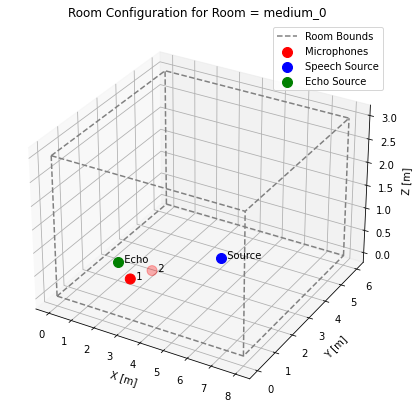

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_room_setup(key, room_sz, mic_array, pos_src):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the room as a wireframe (Cuboid)
    ax.plot([0, room_sz[0], room_sz[0], 0, 0],
            [0, 0, room_sz[1], room_sz[1], 0],
            [0, 0, 0, 0, 0], color="gray", linestyle='--', label="Room Bounds")

    ax.plot([0, room_sz[0], room_sz[0], 0, 0],
            [0, 0, room_sz[1], room_sz[1], 0],
            [room_sz[2], room_sz[2], room_sz[2], room_sz[2], room_sz[2]], color="gray", linestyle='--')

    ax.plot([0, 0], [0, 0], [0, room_sz[2]], color="gray", linestyle='--')
    ax.plot([room_sz[0], room_sz[0]], [0, 0], [0, room_sz[2]], color="gray", linestyle='--')
    ax.plot([room_sz[0], room_sz[0]], [room_sz[1], room_sz[1]], [0, room_sz[2]], color="gray", linestyle='--')
    ax.plot([0, 0], [room_sz[1], room_sz[1]], [0, room_sz[2]], color="gray", linestyle='--')

    # Plot the microphone array
    mic_x = mic_array[:, 0]
    mic_y = mic_array[:, 1]
    mic_z = mic_array[:, 2]

    ax.scatter(mic_x, mic_y, mic_z, color='red', s=100, label='Microphones')

    # Plot the sound source position
    ax.scatter(pos_src[0], pos_src[1], pos_src[2], color='blue', s=100, label='Speech Source')

    # Annotate the positions of microphones and source
    ax.text(mic_x[0], mic_y[0], mic_z[0], '  1', color='black')
    ax.text(mic_x[1], mic_y[1], mic_z[1], '  2', color='black')
    ax.text(pos_src[0], pos_src[1], pos_src[2], '  Source', color='black')
    
    scaling = 4
    deg_60 = math.pi / 3
    mic_1 = np.array([2.0, 1.5, 0.15])
    d = 0.08 * scaling
    mic_2 = mic_1 + np.array([d * math.cos(deg_60*2.5), d * math.sin(deg_60*2.5), 0])
    mic_array = np.array([
        [mic_1[0], mic_1[1], mic_1[2]],
        [mic_2[0], mic_2[1], mic_2[2]],
    ])

    # Generate a random position for the sound source
    d_echo = 0.3*scaling
    echos = mic_1 + np.array([d_echo*math.cos(deg_60*2.5), d_echo*math.sin(deg_60*2.5), 0])
    
    ax.text(echos[0], echos[1], echos[2], '  Echo', color='black')
    ax.scatter(echos[0], echos[1], echos[2], color='green', s=100, label='Echo Source')
    # Set labels
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.set_title(f"Room Configuration for Room = {key}")

    ax.legend()
    plt.show()

# Simulating room and microphone setup
def main(key, room_sz):
    deg_60 = math.pi / 3
    mic_1 = np.array([2.0, 1.5, 0.15])
    d = 0.8
    mic_2 = mic_1 + np.array([d * math.cos(deg_60), d * math.sin(deg_60), 0])
    mic_array = np.array([
        [mic_1[0], mic_1[1], mic_1[2]],
        [mic_2[0], mic_2[1], mic_2[2]],
    ])

    # Generate a random position for the sound source
    x = np.random.uniform(low=0.3, high=room_sz[0] - 0.3)
    y = np.random.uniform(low=0.3, high=room_sz[1] - 0.3)
    z = np.random.uniform(low=1.0, high=1.5)
    pos_src = np.array([x, y, z])  # Source position [m]

    # Plot the room configuration
    plot_room_setup(key, room_sz, mic_array, pos_src)

if __name__ == "__main__":
    rooms = {
        'medium_0': [8, 6, 3],
    }
    for key, room_sz in rooms.items():
        main(key, room_sz)


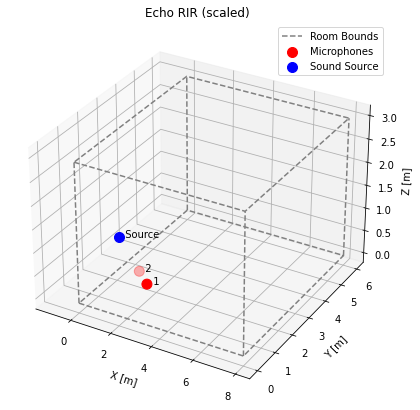

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_room_setup(key, room_sz, mic_array, pos_src):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the room as a wireframe (Cuboid)
    ax.plot([0, room_sz[0], room_sz[0], 0, 0],
            [0, 0, room_sz[1], room_sz[1], 0],
            [0, 0, 0, 0, 0], color="gray", linestyle='--', label="Room Bounds")

    ax.plot([0, room_sz[0], room_sz[0], 0, 0],
            [0, 0, room_sz[1], room_sz[1], 0],
            [room_sz[2], room_sz[2], room_sz[2], room_sz[2], room_sz[2]], color="gray", linestyle='--')

    ax.plot([0, 0], [0, 0], [0, room_sz[2]], color="gray", linestyle='--')
    ax.plot([room_sz[0], room_sz[0]], [0, 0], [0, room_sz[2]], color="gray", linestyle='--')
    ax.plot([room_sz[0], room_sz[0]], [room_sz[1], room_sz[1]], [0, room_sz[2]], color="gray", linestyle='--')
    ax.plot([0, 0], [room_sz[1], room_sz[1]], [0, room_sz[2]], color="gray", linestyle='--')

    # Plot the microphone array
    mic_x = mic_array[:, 0]
    mic_y = mic_array[:, 1]
    mic_z = mic_array[:, 2]

    ax.scatter(mic_x, mic_y, mic_z, color='red', s=100, label='Microphones')

    # Plot the sound source position
    ax.scatter(pos_src[0], pos_src[1], pos_src[2], color='blue', s=100, label='Sound Source')

    # Annotate the positions of microphones and source
    ax.text(mic_x[0], mic_y[0], mic_z[0], '  1', color='black')
    ax.text(mic_x[1], mic_y[1], mic_z[1], '  2', color='black')
    ax.text(pos_src[0], pos_src[1], pos_src[2], '  Source', color='black')

    # Set labels
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.set_title(f"Echo RIR (scaled)")

    ax.legend()
    plt.show()

# Simulating room and microphone setup
def main(key, room_sz):
    scaling = 12
    deg_60 = math.pi / 3
    mic_1 = np.array([2.0, 1.5, 0.15])
    d = 0.08 * scaling
    mic_2 = mic_1 + np.array([d * math.cos(deg_60*2.5), d * math.sin(deg_60*2.5), 0])
    mic_array = np.array([
        [mic_1[0], mic_1[1], mic_1[2]],
        [mic_2[0], mic_2[1], mic_2[2]],
    ])

    # Generate a random position for the sound source
    d_echo = 0.3*scaling
    pos_src = mic_1 + np.array([d_echo*math.cos(deg_60*2.5), d_echo*math.sin(deg_60*2.5), 0])
    # Plot the room configuration
    plot_room_setup(key, room_sz, mic_array, pos_src)

if __name__ == "__main__":
    rooms = {
        'medium_0': [8, 6, 3],
    }
    for key, room_sz in rooms.items():
        main(key, room_sz)
